In [1]:
# Notebook setup
import os
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 2

### Load dataset (test model with 100 perturbations from 3 datasets)

In [2]:
import scanpy as sc

metaset_path = '/home/xlv0877/proj_home/dl/data/test/1000/mixscale_2degs/mixscale_filtered_w_emb.h5ad'
adata = sc.read(metaset_path)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

### Setup adata

In [3]:
# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42
model_dir = 'models/disentangle_losses'
# define all labels to classify on
cls_labels = ['celltype', 'perturbation_type', 'perturbation']
# create classification label
adata.obs['cls_label'] = adata.obs[cls_labels].agg(';'.join, axis=1)
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'
# add status label (control or perturbed)
adata.obs['status'] = 'perturbed'
adata.obs.loc[adata.obs['perturbation'] == 'control', 'status'] = 'ctrl'
# remove perturbations with less than minimum amount of cells
min_cells = 10
p_summary = adata.obs.cls_label.value_counts()
valid_perturbations = p_summary[p_summary >= min_cells].index
adata._inplace_subset_obs(adata.obs.cls_label.isin(valid_perturbations))

In [4]:
# Take a few perturbations out to predict later
N = 100
M = 10
idx = np.where(adata.obs[cls_labels[-1]].isin(adata.obs[cls_labels[-1]].value_counts()[:N].index))[0]
idx_unseen = np.where(adata.obs[cls_labels[-1]].isin(adata.obs[cls_labels[-1]].value_counts()[N:N+M].index))[0]
unseen_adata = adata[idx_unseen].copy()
adata._inplace_subset_obs(idx)

### Filter by mixscale score (optional if already filtered)

In [5]:
# Filter for mixscale score
mst = 0.5
ms_mask = (adata.obs['mixscale_score'].abs() > mst) | (adata.obs['perturbation']=='control')
adata._inplace_subset_obs(ms_mask)
cpp = adata.obs.perturbation.value_counts()
logging.info(f'Filtering for mixscale score > {mst}, mean number of cells / perturbation: {cpp[1:].mean()}')
logging.info(f'Filtered for {np.sum(ms_mask)}/{len(ms_mask)} cells')

2025-05-12 10:36:06,180 - INFO - Filtering for mixscale score > 0.5, mean number of cells / perturbation: 667.4848484848485
2025-05-12 10:36:06,182 - INFO - Filtered for 160977/160977 cells


### Subset control cells for each celltype / dataset

In [6]:
from src.sampling import sample_from_ctrl_cells

adata = sample_from_ctrl_cells(
    adata, cls_labels=['celltype', 'perturbation_type', 'perturbation'], n_ctrl=1000
).copy()

2025-05-12 10:36:42,598 - INFO - Resulting set has 68081 cells.


### Remove perturbations that do not have an embedding

In [7]:
# Select cells that have a match in the embedding
cells_annotated_mask = adata.obsm['gene_embedding'].sum(axis=1).A1!=0
# Select control cells to keep
ctrl_mask = adata.obs['perturbation']=='control'
embedding_mask = (cells_annotated_mask | ctrl_mask)
adata._inplace_subset_obs(embedding_mask)
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {adata.obs.cls_label.nunique()} classes')

2025-05-12 10:37:01,391 - INFO - Initializing dataset with 196 classes


In [8]:
# choose set to train on
copy = False
likelihood = 'zinb'

if copy:
    logging.info('Copying adata (will double the RAM usage)')
    model_set = adata.copy()
else:
    model_set = adata

if likelihood == 'normal':
    logging.info('Applying log1p and scaling data to force normal distribution')
    sc.pp.log1p(model_set)
    sc.pp.scale(model_set)
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {model_set.obs.cls_label.nunique()} classes')
logging.info(f'Mean number of cells / perturbation {model_set.obs.cls_label.value_counts().mean()}')

2025-05-12 10:37:12,307 - INFO - Initializing dataset with 196 classes
2025-05-12 10:37:12,317 - INFO - Mean number of cells / perturbation 340.34183673469386


### Base hyperparameters

In [33]:
import torch
from src.models._gedvi import GEDVI
from src.plotting import get_model_results

# set model dir
class_labels = model_set.obs[cls_label].unique()
n_labels = len(class_labels)-1 if 'unknown' in class_labels else len(class_labels)  
# set scale for kl divergence
recon_weight = 1
klr = 0.25
g_weight = 0      # Pair-wise distance stuff
contrastive_y = 0.25
contrastive_loss_weight = 1
contrastive_margin = 1
g_classification_weight = 1
cr = 1
adjust_by_mean = True

# hyperparameters for model
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1
}
gedvae_params = {
    'n_hidden': 128,
    'n_latent': 100,
    'n_latent_g': 100,
    'n_layers_encoder': 1,
    'n_layers_encoder_g': 1,
    'n_layers_decoder': 1,
    'dropout_rate_encoder': 0.2,
    'dropout_rate_encoder_g': 0.1,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'use_posterior_mean': False,
    'log_variational': likelihood == 'zinb',
    'normalize_recon_loss': None,
    'g_weight': g_weight,
    'g_activation': None,
    'contrastive_y': contrastive_y,
    'contrastive_loss_weight': contrastive_loss_weight,
    'contrastive_margin': contrastive_margin,
    'recon_weight': recon_weight,
    'adjust_by_mean': adjust_by_mean,
    'g_classification_weight': g_classification_weight
}

tensor_dir = os.path.join(model_dir, f'n_{n_labels}')

data_params = {
    'train_size': 0.9,
    'batch_size': 128,
    'num_workers': 1,
    'shuffle_train': False,     # Make it reproducible
}
plan_params = {
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'kl_weight': klr,
    'classification_ratio': cr,
    'lr_scheduler_metric': 'elbo_validation',
    'plot_cm': True, 'plot_umap': False
}
train_params = {
    'max_epochs': 85,
    'early_stopping': False,
    'check_val_every_n_epoch': 1,
    'logger': pl.loggers.TensorBoardLogger(tensor_dir),
    'plan_kwargs': plan_params,
}
# Define covariates, set celltype as covariate
cat_covs = None
cont_covs = None

torch.set_float32_matmul_precision('medium')
torch.manual_seed(seed)
np.random.seed(seed)

#### Step 1: Reconstruction only

INFO     Generating sequential column names                                                                        


2025-05-12 13:10:14,705 - INFO - Running at: models/disentangle_losses/rl_only
2025-05-12 13:10:14,707 - INFO - Epochs suggested: 120, training for 85 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-12 13:10:15,903 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-12 13:10:15,906 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-12 13:10:15,907 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-12 13:10:15,929 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-12 13:10:15,955 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/

Training:   0%|          | 0/85 [00:00<?, ?it/s]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/e

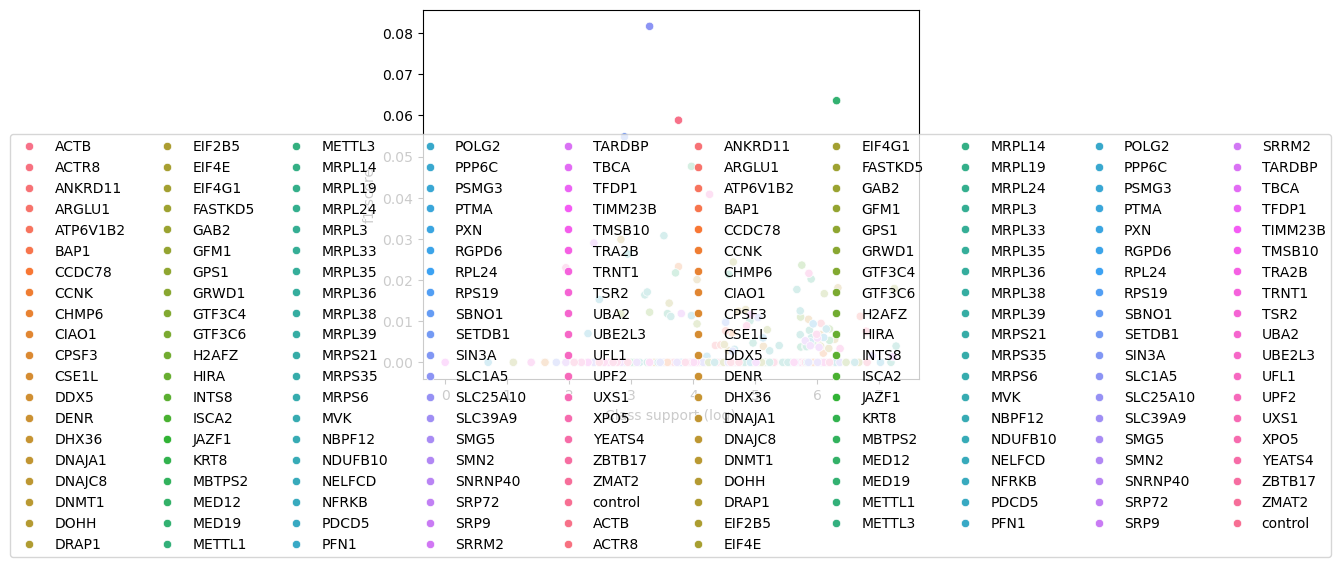

In [35]:
gedvae_params['recon_weight'] = 1                  # Reconstruction loss
plan_params['kl_weight'] = 0                       # KL divergence loss
plan_params['classification_ratio'] = 0            # Classification loss (zx)
gedvae_params['g_classification_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl_only')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    cls_labels=cls_labels,
    categorical_covariate_keys=cat_covs,
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params)
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

#### Step 2: Incl. KL loss

INFO     Generating sequential column names                                                                        


2025-05-12 13:52:59,083 - INFO - Running at: models/disentangle_losses/rl+kl
2025-05-12 13:52:59,085 - INFO - Epochs suggested: 120, training for 85 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-12 13:52:59,929 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-12 13:52:59,932 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-12 13:52:59,934 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-12 13:52:59,959 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-12 13:52:59,987 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/py

Training:   0%|          | 0/85 [00:00<?, ?it/s]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/e

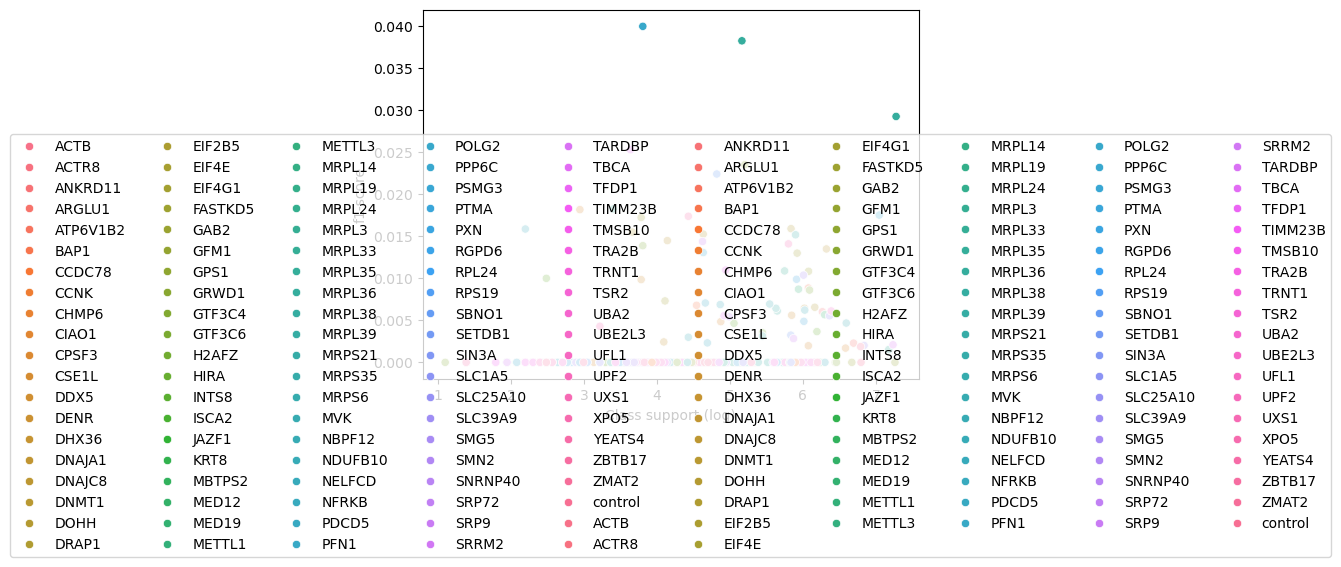

In [36]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
gedvae_params['recon_weight'] = 1                  # Reconstruction loss
plan_params['kl_weight'] = 1                       # KL divergence loss
plan_params['classification_ratio'] = 0            # Classification loss (zx)
gedvae_params['g_classification_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
train_params['plan_kwargs'] = plan_params          # Update plan params
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    cls_labels=cls_labels,
    categorical_covariate_keys=cat_covs,
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

#### Step 3: Incl. Classification loss

In [ ]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
gedvae_params['recon_weight'] = 1                  # Reconstruction loss
plan_params['kl_weight'] = 1                       # KL divergence loss
plan_params['classification_ratio'] = 1            # Classification loss (zx)
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['g_classification_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
train_params['plan_kwargs'] = plan_params          # Update plan params
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    cls_labels=cls_labels,
    categorical_covariate_keys=cat_covs,
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

INFO     Generating sequential column names                                                                        


2025-05-12 14:41:04,702 - INFO - Running at: models/disentangle_losses/rl+kl+c
2025-05-12 14:41:04,704 - INFO - Epochs suggested: 120, training for 85 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-12 14:41:05,672 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-12 14:41:05,675 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-12 14:41:05,677 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-12 14:41:05,702 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-12 14:41:05,730 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/

Training:   0%|          | 0/85 [00:00<?, ?it/s]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xlv0877/.conda/e

#### Step 4: Add zg classification

INFO     Generating sequential column names                                                                        


2025-05-09 23:01:18,204 - INFO - Running at: models/disentangle_losses/rl+kl+c+czg
2025-05-09 23:01:18,205 - INFO - Epochs suggested: 120, training for 125 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-09 23:01:18,392 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-09 23:01:18,393 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-09 23:01:18,393 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-09 23:01:18,400 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-09 23:01:18,415 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl

Training:   0%|          | 0/125 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=125` reached.
2025-05-09 23:41:38,512 - INFO - `Trainer.fit` stopped: `max_epochs=125` reached.
2025-05-09 23:41:39,012 - INFO - Processing train set
2025-05-09 23:41:54,376 - INFO - Calculating latent neighbors
2025-05-09 23:42:03,423 - INFO - Calculating latent umap
2025-05-09 23:43:10,217 - INFO - Plotting train for label: celltype
... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'scanvi_predictions' as categorical
2025-05-09 23:43:13,136 - INFO - Plotting train for label: perturbation_type
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-05-09 23:43:15,735 - INFO - Plotting train for label: perturbation
2025-05-09 23:43:21,454 - INFO - Plotting train for label: datas

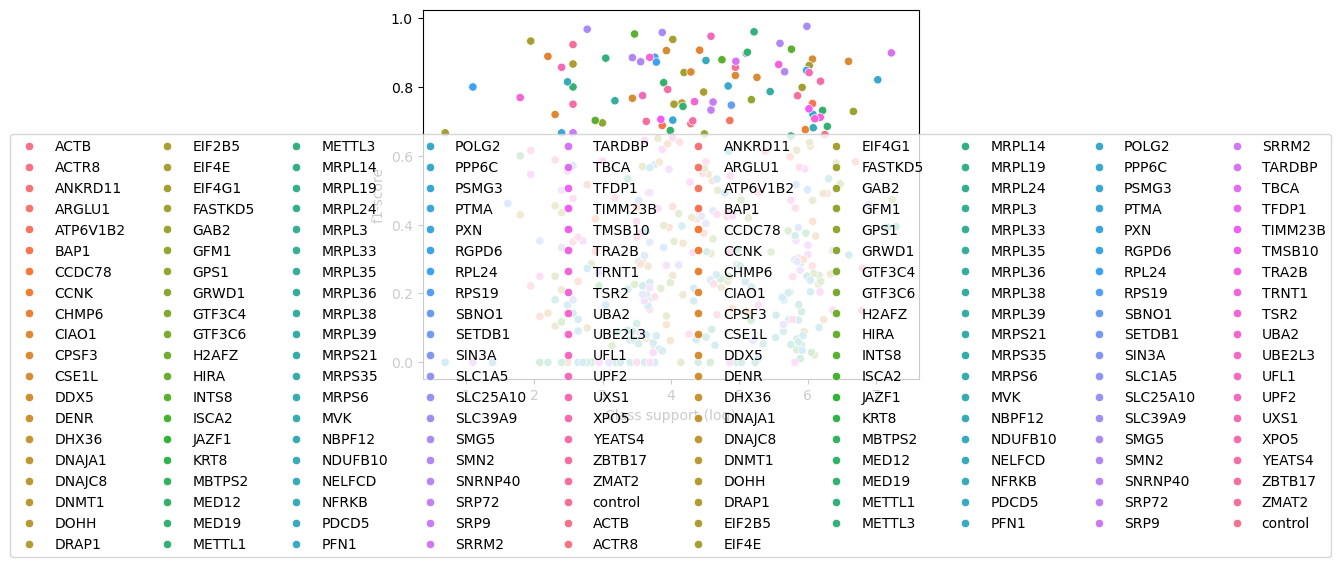

In [51]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c+czg')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
gedvae_params['recon_weight'] = 1                  # Reconstruction loss
plan_params['kl_weight'] = 1                       # KL divergence loss
plan_params['classification_ratio'] = 1            # Classification loss (zx)
gedvae_params['g_classification_weight'] = 1       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
train_params['plan_kwargs'] = plan_params          # Update plan params
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    cls_labels=cls_labels,
    categorical_covariate_keys=cat_covs,
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

In [ ]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c+czg+contr')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
gedvae_params['recon_weight'] = 1                  # Reconstruction loss
plan_params['kl_weight'] = 0.0                       # KL divergence loss
plan_params['classification_ratio'] = 10            # Classification loss (zx)
gedvae_params['g_classification_weight'] = 10       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 100       # Classification loss (zxg)
gedvae_params['contrastive_y'] = 0.0               # Contrastive Y (0=similar, 1=dissimilar)
train_params['plan_kwargs'] = plan_params          # Update plan params
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    cls_labels=cls_labels,
    categorical_covariate_keys=cat_covs,
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

INFO     Generating sequential column names                                                                        


2025-05-10 00:45:04,012 - INFO - Running at: models/disentangle_losses/rl+kl+c+czg+contr
2025-05-10 00:45:04,013 - INFO - Epochs suggested: 120, training for 125 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-10 00:45:04,205 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-10 00:45:04,206 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-10 00:45:04,207 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-10 00:45:04,214 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-10 00:45:04,229 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/env

Training:   0%|          | 0/125 [00:00<?, ?it/s]

### Test on unseen k562 dataset